In [1]:
!pip3 install git+https://github.com/zalandoresearch/flair

  Cloning https://github.com/zalandoresearch/flair to /tmp/pip-req-build-x5hxoil6
  Running command git clone -q https://github.com/zalandoresearch/flair /tmp/pip-req-build-x5hxoil6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 143kB 8.8MB/s eta 0:00:01


  Created wheel for flair: filename=flair-0.4.2-cp36-none-any.whl size=102754 sha256=6580386d954f2415d7dcaed473997bd6b0c0a0c02ff54ab90243894288bfd393
  Stored in directory: /tmp/pip-ephem-wheel-cache-384cr330/wheels/8e/47/da/f22675cf094ae69648b301413ef8639296775f876b38a5507f
Successfully built flair
  Created wheel for sqlitedict: filename=sqlitedict-1.6.0-cp36-none-any.whl size=14689 sha256=f1e2478a47637bde319eb96d7f11591cc530347d5cc663c9c805b6379f40ee27
  Stored in directory: /tmp/.cache/pip/wheels/bd/57/d3/907c3ee02d35e66f674ad0106e61f06eeeb98f6ee66a6cc3fe
  Created wheel for segtok: filename=segtok-1.5.7-cp36-none-any.whl size=23257 sha256=f21f07bbd65eb0aa06785f91680903baf5a907a47f05eb14e774dba5ee258b39
  Stored in directory: /tmp/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
Successfully built sqlitedict segtok
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import pandas as pd

%matplotlib inline

import torch
torch.cuda.is_available()

True

> ## Create a Corpus

### 1) Load from simple CSV file

In [3]:
from flair.datasets import CSVClassificationCorpus

Great development..

### 2) FastText Format

In [4]:
from flair.data import Corpus
from flair.datasets import ClassificationCorpus

In [5]:
FILE_PATH = "../input/bbc-text.csv"
DATASET_FOLDER_PATH = "splitted_data"
# DATASET_FOLDER_PATH = os.path.join("splitted_data", FILE_PATH.split(".")[0].split("/")[1])

column_name = {
    "text": "text",
    "label": "category"
}

# file format
__label__<label_1> <text>
__label__<label_1> __label__<label_2> <text>

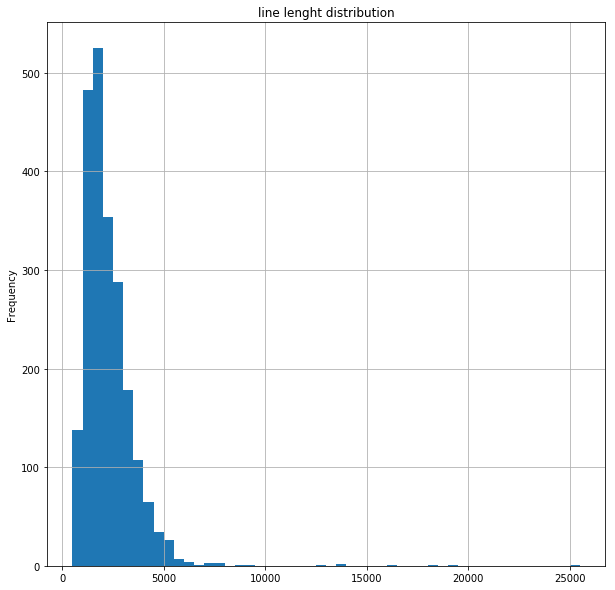

In [6]:
data_df = pd.read_csv(FILE_PATH).sample(frac=1)
data_df[column_name["label"]] = '__label__' + data_df[column_name["label"]].astype(str)

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

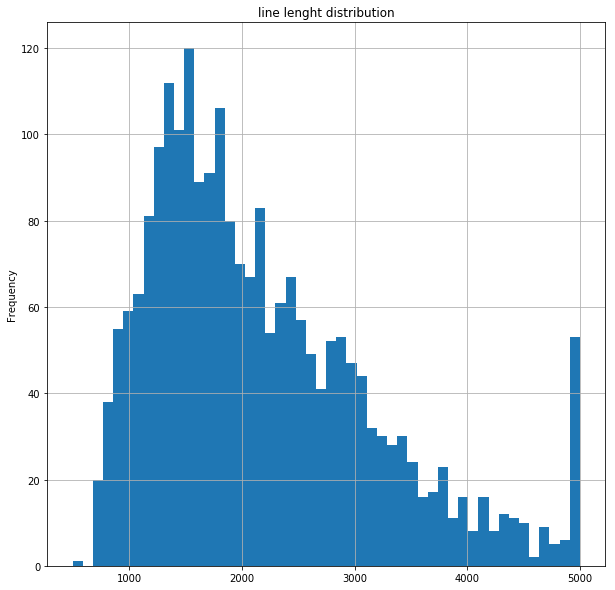

In [7]:
import re
from string import digits, punctuation

def clear_text(text, is_all_lower=True):
    punct = re.sub(r'[\.,!?&\-]', '', punctuation)
    punctuation_table = str.maketrans({key: "#" for key in punct})
    for char in ["\"", "\'"]:
        del punctuation_table[ord(char)]
    
    review_cleaned = text.apply(lambda x: re.sub(r'[^\x00-\x7F]', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r'[0-9]', '9', x))
    review_cleaned = review_cleaned.apply(lambda x: x.translate(punctuation_table))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' +', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' (?=[\.,!?&\-])','', x))
    
    if is_all_lower:
        review_cleaned = review_cleaned.str.lower()
        
    return review_cleaned

data_df[column_name["text"]] = clear_text(data_df["text"])
data_df[column_name["text"]] = data_df[column_name["text"]].apply(lambda x: x[:5000])

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

In [8]:
if not os.path.exists(DATASET_FOLDER_PATH):
    os.makedirs(DATASET_FOLDER_PATH)
data_df.iloc[0: int(len(data_df)*0.8)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'train.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.8): int(len(data_df)*0.9)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'dev.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.9): ].to_csv(os.path.join(DATASET_FOLDER_PATH, 'test.csv'), sep='\t', index = False, header = False);

In [9]:
corpus = ClassificationCorpus(DATASET_FOLDER_PATH)

2019-08-11 21:00:45,251 Reading data from splitted_data
2019-08-11 21:00:45,252 Train: splitted_data/train.csv
2019-08-11 21:00:45,258 Dev: splitted_data/dev.csv
2019-08-11 21:00:45,259 Test: splitted_data/test.csv


Each line in a corpus is converted to a Sentence object annotated with the labels.

## Check distribution

In [10]:
train_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "train.csv"), names=["label", "text"], delimiter="\t")
train_df.label.value_counts()

__label__sport            422
__label__business         395
__label__politics         347
__label__tech             320
__label__entertainment    296
Name: label, dtype: int64

In [11]:
val_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "dev.csv"), names=["label", "text"], delimiter="\t")
val_df.label.value_counts()

__label__entertainment    53
__label__business         52
__label__sport            45
__label__politics         39
__label__tech             33
Name: label, dtype: int64

In [12]:
test_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "test.csv"), names=["label", "text"], delimiter="\t")
test_df.label.value_counts()

__label__business         63
__label__tech             48
__label__sport            44
__label__entertainment    37
__label__politics         31
Name: label, dtype: int64

## Training a Model

## XLNet

In [13]:
from flair.embeddings import XLNetEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.training_utils import EvaluationMetric
# from flair.visual.training_curves import Plotter

In [14]:
MODEL_FOLDER_PATH = "model/XLNet"
if not os.path.exists(MODEL_FOLDER_PATH):
    os.makedirs(MODEL_FOLDER_PATH)

In [15]:
params_train = {
    "flair_emb_forward": 'news-forward-fast',
    "flair_emb_backward": 'news-backward-fast',
    "hidden_size": 256,
    "reproject_words_dimension": 128,
    "max_epoch": 20,
    "evaluation_metric": EvaluationMetric.MICRO_ACCURACY
}

word_embeddings = [XLNetEmbeddings(), FlairEmbeddings(params_train["flair_emb_forward"]),
                   FlairEmbeddings(params_train["flair_emb_backward"])]

document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=params_train["hidden_size"],
                                            reproject_words=True, reproject_words_dimension=params_train["reproject_words_dimension"])

classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary(), multi_label=False)

trainer = ModelTrainer(classifier, corpus)

100%|██████████| 1441285815/1441285815 [00:52<00:00, 27295175.13B/s]


2019-08-11 21:02:26,162 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-forward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmp2m7rjwdt


100%|██████████| 19689779/19689779 [00:00<00:00, 41625777.83B/s]

2019-08-11 21:02:26,819 copying /tmp/tmp2m7rjwdt to cache at /tmp/.flair/embeddings/lm-news-english-forward-1024-v0.2rc.pt


2019-08-11 21:02:26,851 removing temp file /tmp/tmp2m7rjwdt
2019-08-11 21:02:27,006 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-backward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmp90aovujn


100%|██████████| 19689779/19689779 [00:00<00:00, 42495572.82B/s]

2019-08-11 21:02:27,623 copying /tmp/tmp90aovujn to cache at /tmp/.flair/embeddings/lm-news-english-backward-1024-v0.2rc.pt
2019-08-11 21:02:27,657 removing temp file /tmp/tmp90aovujn


2019-08-11 21:02:27,742 Computing label dictionary. Progress:


100%|██████████| 1780/1780 [00:23<00:00, 74.77it/s]

2019-08-11 21:02:52,028 [b'tech', b'politics', b'business', b'sport', b'entertainment']


In [ ]:
learning_rate_tsv = trainer.find_learning_rate(MODEL_FOLDER_PATH, 'learning_rate.tsv')

plotter = Plotter()
plotter.plot_learning_rate(learning_rate_tsv)

In [16]:
trainer.train(MODEL_FOLDER_PATH, max_epochs=params_train["max_epoch"])#, evaluation_metric=params_train["evaluation_metric"])

2019-08-11 21:02:52,047 ----------------------------------------------------------------------------------------------------
2019-08-11 21:02:52,053 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): XLNetEmbeddings(
        model=xlnet-large-cased
        (model): XLNetModel(
          (word_embedding): Embedding(32000, 1024)
          (layer): ModuleList(
            (0): XLNetLayer(
              (rel_attn): XLNetRelativeAttention(
                (layer_norm): XLNetLayerNorm()
                (dropout): Dropout(p=0.1)
              )
              (ff): XLNetFeedForward(
                (layer_norm): XLNetLayerNorm()
                (layer_1): Linear(in_features=1024, out_features=4096, bias=True)
                (layer_2): Linear(in_features=4096, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (dropout): Dropout(p=0.1)
            )
           

2019-08-11 21:02:52,055 ----------------------------------------------------------------------------------------------------
2019-08-11 21:02:52,057 Corpus: "Corpus: 1780 train + 222 dev + 223 test sentences"
2019-08-11 21:02:52,059 ----------------------------------------------------------------------------------------------------
2019-08-11 21:02:52,060 Parameters:
2019-08-11 21:02:52,062  - learning_rate: "0.1"
2019-08-11 21:02:52,063  - mini_batch_size: "32"
2019-08-11 21:02:52,065  - patience: "3"
2019-08-11 21:02:52,066  - anneal_factor: "0.5"
2019-08-11 21:02:52,068  - max_epochs: "20"
2019-08-11 21:02:52,069  - shuffle: "True"
2019-08-11 21:02:52,070  - train_with_dev: "False"
2019-08-11 21:02:52,070 ----------------------------------------------------------------------------------------------------
2019-08-11 21:02:52,071 Model training base path: "model/XLNet"
2019-08-11 21:02:52,072 ---------------------------------------------------------------------------------------------

2019-08-11 21:48:26,783 epoch 5 - iter 35/56 - loss 0.37509374 throughput (samples/sec): 3.50
2019-08-11 21:49:14,546 epoch 5 - iter 40/56 - loss 0.37047550 throughput (samples/sec): 3.45
2019-08-11 21:49:59,658 epoch 5 - iter 45/56 - loss 0.36532876 throughput (samples/sec): 3.66
2019-08-11 21:50:41,555 epoch 5 - iter 50/56 - loss 0.36349464 throughput (samples/sec): 3.92
2019-08-11 21:51:24,764 epoch 5 - iter 55/56 - loss 0.36419871 throughput (samples/sec): 3.78
2019-08-11 21:51:25,359 ----------------------------------------------------------------------------------------------------
2019-08-11 21:51:25,360 EPOCH 5 done: loss 0.3642 - lr 0.1000
2019-08-11 21:52:33,215 DEV : loss 0.7668599486351013 - score 0.7432
2019-08-11 21:52:38,214 BAD EPOCHS (no improvement): 0
2019-08-11 21:52:40,510 ----------------------------------------------------------------------------------------------------
2019-08-11 21:52:57,845 epoch 6 - iter 0/56 - loss 0.35556152 throughput (samples/sec): 15.27


2019-08-11 22:40:53,156 epoch 10 - iter 55/56 - loss 0.06143723 throughput (samples/sec): 4.01
2019-08-11 22:40:53,775 ----------------------------------------------------------------------------------------------------
2019-08-11 22:40:53,776 EPOCH 10 done: loss 0.0614 - lr 0.1000
2019-08-11 22:42:00,365 DEV : loss 0.44395333528518677 - score 0.8649
2019-08-11 22:42:05,619 BAD EPOCHS (no improvement): 0
2019-08-11 22:42:07,901 ----------------------------------------------------------------------------------------------------
2019-08-11 22:42:22,651 epoch 11 - iter 0/56 - loss 0.02941830 throughput (samples/sec): 13.21
2019-08-11 22:43:09,046 epoch 11 - iter 5/56 - loss 0.03640752 throughput (samples/sec): 3.55
2019-08-11 22:43:54,175 epoch 11 - iter 10/56 - loss 0.03933015 throughput (samples/sec): 3.70
2019-08-11 22:44:41,842 epoch 11 - iter 15/56 - loss 0.03523559 throughput (samples/sec): 3.50
2019-08-11 22:45:29,287 epoch 11 - iter 20/56 - loss 0.03409601 throughput (samples/sec)

2019-08-11 23:31:45,378 BAD EPOCHS (no improvement): 1
2019-08-11 23:31:47,798 ----------------------------------------------------------------------------------------------------
2019-08-11 23:32:02,593 epoch 16 - iter 0/56 - loss 0.01503138 throughput (samples/sec): 13.20
2019-08-11 23:32:49,879 epoch 16 - iter 5/56 - loss 0.00810531 throughput (samples/sec): 3.49
2019-08-11 23:33:34,731 epoch 16 - iter 10/56 - loss 0.00848951 throughput (samples/sec): 3.68
2019-08-11 23:34:20,931 epoch 16 - iter 15/56 - loss 0.00873140 throughput (samples/sec): 3.59
2019-08-11 23:35:08,821 epoch 16 - iter 20/56 - loss 0.01021040 throughput (samples/sec): 3.44
2019-08-11 23:35:52,216 epoch 16 - iter 25/56 - loss 0.01102074 throughput (samples/sec): 3.77
2019-08-11 23:36:38,986 epoch 16 - iter 30/56 - loss 0.01100238 throughput (samples/sec): 3.49
2019-08-11 23:37:24,549 epoch 16 - iter 35/56 - loss 0.01081148 throughput (samples/sec): 3.60
2019-08-11 23:38:14,540 epoch 16 - iter 40/56 - loss 0.011496

2019-08-12 00:22:11,929 
MICRO_AVG: acc 0.813 - f1-score 0.8969
MACRO_AVG: acc 0.8082 - f1-score 0.8933
business   tp: 54 - fp: 2 - fn: 9 - tn: 158 - precision: 0.9643 - recall: 0.8571 - accuracy: 0.8308 - f1-score: 0.9075
entertainment tp: 32 - fp: 5 - fn: 5 - tn: 181 - precision: 0.8649 - recall: 0.8649 - accuracy: 0.7619 - f1-score: 0.8649
politics   tp: 29 - fp: 7 - fn: 2 - tn: 185 - precision: 0.8056 - recall: 0.9355 - accuracy: 0.7632 - f1-score: 0.8657
sport      tp: 42 - fp: 8 - fn: 2 - tn: 171 - precision: 0.8400 - recall: 0.9545 - accuracy: 0.8077 - f1-score: 0.8936
tech       tp: 43 - fp: 1 - fn: 5 - tn: 174 - precision: 0.9773 - recall: 0.8958 - accuracy: 0.8776 - f1-score: 0.9348
2019-08-12 00:22:11,932 ----------------------------------------------------------------------------------------------------


{'test_score': 0.8969,
 'dev_score_history': [0.3333,
  0.5586,
  0.6802,
  0.7387,
  0.7432,
  0.8288,
  0.8288,
  0.8604,
  0.8243,
  0.8649,
  0.8739,
  0.8739,
  0.8649,
  0.8784,
  0.8784,
  0.8874,
  0.8919,
  0.9009,
  0.8874,
  0.8829],
 'train_loss_history': [1.6990104424101966,
  1.258944992508207,
  0.8399542005998748,
  0.523381558912141,
  0.36419871023723055,
  0.23828042950481176,
  0.15946949226781726,
  0.1130081759433129,
  0.07631825782092554,
  0.061437229925234406,
  0.0351566451468638,
  0.028095657138952186,
  0.02278229793799775,
  0.012310581653894457,
  0.01427818974480033,
  0.010848539004135611,
  0.009249894505566252,
  0.009723590953009469,
  0.007152717851568013,
  0.008916460455761157],
 'dev_loss_history': [tensor(1.5112, device='cuda:0'),
  tensor(1.1444, device='cuda:0'),
  tensor(0.9159, device='cuda:0'),
  tensor(0.7609, device='cuda:0'),
  tensor(0.7669, device='cuda:0'),
  tensor(0.5352, device='cuda:0'),
  tensor(0.4873, device='cuda:0'),
  tenso

## Plot training curves

In [ ]:
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves(os.path.join(MODEL_FOLDER_PATH, 'loss.tsv'))
plotter.plot_weights(os.path.join(MODEL_FOLDER_PATH, 'weights.txt'))